In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
from scipy import stats
from statistics import stdev, mean
import random

NUM_INTENTS = 10
NLU_NAMES = ['watson', 'luis', 'snips', 'rasa-sklearn', 'rasa-diet']
COLORS = ['lightcoral', 'yellowgreen', 'deepskyblue', 'purple', 'mediumturquoise', 'mediumorchid', 'khaki', 'salmon', 'darkturquoise', 'gold']
VERSION = 8
NUM_SPLITS = 10

def load_json(path):
    with open(path) as json_file:
        data = json.load(json_file)
    return data

def remove_empty_preds(data):
    new_data = []
    for test in data:
        if test['text'] != '':
            new_data.append(test)
    return new_data

def get_nlu_result_file(nlu, version, split_num):
    nlu_result_file = '../results/' + nlu + '/v' + str(version) + '/' + nlu + '_split_' + str(split_num) + '_results_v' + str(version) + '.json'
    return nlu_result_file

def get_confidence_score(test, rank=0, nlu="watson", level="rank"):
    """
    the output of this function differs depending on the level.
    On rank level, the output is a single float that represents the confidence score of a rank 
    On model level, the output is a list of floats that includes the confidence scores of all ranks
    """
    if level == "rank":
        predicted_intent_conf = test['intent_ranking'][rank]['confidence'] # rasa
        return predicted_intent_conf 
    
    else: # level == "model"
        predicted_confidences = [rank['confidence'] for rank in test['intent_ranking']]
        return predicted_confidences
    
def get_accuracy(test, rank=0, nlu="watson", level="rank"):
    """
    the output of this function differs depending on the level.
    On rank level, the output is a single int that represents the instance-level accuracy of a rank
    On model level, the output is a list of ints that includes the instance-level accuracies of all ranks
    """
    correct_intent = test['correct_intent']
    if level == "rank":
        predicted_intent = test['intent_ranking'][rank]['name']
        accuracy = int(correct_intent == predicted_intent)
        return accuracy
    else:
        test_accuracies = []
        test_accuracies = [rank['name'] == correct_intent for rank in test['intent_ranking']]
        return test_accuracies
    
def show_reliability_plot(fig, ax, diagram_output_file, plot_title, x_axis_desc='Predicted confidences', y_axis_desc='Accuracy in each bin', yaxis_range=[], save=True, line=True):
    # reference line, legends, and axis labels
    if line:
        line = mlines.Line2D([0, 1], [0, 1], color='black') # perfectly-calibrated model
        transform = ax.transAxes 
        line.set_transform(transform)
        ax.add_line(line)
    plt.legend()
    fig.suptitle(plot_title)
    ax.set_xlabel(x_axis_desc)
    ax.set_ylabel(y_axis_desc)
    if yaxis_range != []:
        plt.ylim(yaxis_range)

    if save:
        plt.savefig(diagram_output_file)
    plt.show()
    
def normalize(vector):
    normalized_vector = [v/sum(vector) for v in vector]
    return normalized_vector

In [46]:
def set_random_descending_scores(test):
    scores = sorted([random.uniform(0,1) for _ in range(NUM_INTENTS)], key=lambda x: -x)
    if nlu == 'watson':
        scores = normalize(scores)
    for i in range(NUM_INTENTS):
        test['intent_ranking'][i]['confidence'] = scores[i]
        
def set_uniform_descending_scores(test):
    for i in range(NUM_INTENTS):
        test['intent_ranking'][i]['confidence'] = 1 - i/NUM_INTENTS


## Model level

In [47]:
all_nlus_correlations = [] 
for i, nlu in enumerate(NLU_NAMES): 
    nlu_correlations = []
    for iteration in range(NUM_SPLITS):
        split_num = iteration + 1
        # load nlu results
        nlu_result_file = get_nlu_result_file(nlu, VERSION, split_num)
        data = remove_empty_preds(load_json(nlu_result_file))
        
        # uncomment the following line to normalize the data
        # data = normalize_data(nlu, data)

        # get confidence scores and [binary] accuracy for a specific nlu rank
        nlu_confidences = []
        nlu_accuracies = []
        for test in data:
            set_random_descending_scores(test)
            #set_uniform_descending_scores(test)
            predicted_confidences = get_confidence_score(test, nlu=nlu, level="model")
            test_accuracies = get_accuracy(test, nlu=nlu, level="model")

            nlu_confidences.extend(predicted_confidences)
            nlu_accuracies.extend(test_accuracies)

        # perform spearman correlation per nlu rank
        correlation, pvalue = stats.spearmanr(nlu_confidences, nlu_accuracies, nan_policy='omit')
        nlu_correlations.append(correlation)
    
        
    averaged_correlation = sum(nlu_correlations) / len(nlu_correlations)
    sd = stdev(nlu_correlations)
    median = np.median(nlu_correlations)
    all_nlus_correlations.append({'nlu' : nlu , 'correlation' : averaged_correlation, 'median': median, 'pvalue' : pvalue, 'standard deviation' : sd})
    
all_nlus_correlations

[{'nlu': 'watson',
  'correlation': 0.45377094222032344,
  'median': 0.4537748121613151,
  'pvalue': 0.0,
  'standard deviation': 0.0011836248168367374},
 {'nlu': 'luis',
  'correlation': 0.4387487258983467,
  'median': 0.43861775028453936,
  'pvalue': 0.0,
  'standard deviation': 0.0005817019340152206},
 {'nlu': 'snips',
  'correlation': 0.4519508867178466,
  'median': 0.45176082770708176,
  'pvalue': 0.0,
  'standard deviation': 0.0007415730339447699},
 {'nlu': 'rasa-sklearn',
  'correlation': 0.45292236854161594,
  'median': 0.4528675885179956,
  'pvalue': 0.0,
  'standard deviation': 0.000725405703143492},
 {'nlu': 'rasa-diet',
  'correlation': 0.44836207517435234,
  'median': 0.44848776158789383,
  'pvalue': 0.0,
  'standard deviation': 0.0013757696988407166}]

## Rank level

In [48]:
all_nlus_correlations = [] 
all_tabs = []
for rank in range(NUM_INTENTS):
    for i, nlu in enumerate(NLU_NAMES): 
        nlu_rank_correlations = []
        sds = []
        for iteration in range(NUM_SPLITS):
            split_num = iteration + 1
            # load nlu results
            nlu_result_file = get_nlu_result_file(nlu, VERSION, split_num)
            data = remove_empty_preds(load_json(nlu_result_file))
            
            # uncomment the following line to normalize the data
            # data = normalize_data(nlu, data)

            # get confidence scores and [binary] accuracy for a specific nlu rank
            nlu_confidences = []
            nlu_accuracies = []
            for test in data:
                set_random_descending_scores(test)
                predicted_intent_conf = get_confidence_score(test, rank=rank, nlu=nlu, level="rank")

                predicted_intent_acc = get_accuracy(test, rank=rank, nlu=nlu, level="rank")
                nlu_confidences.append(predicted_intent_conf)
                nlu_accuracies.append(predicted_intent_acc)
            

            # perform spearman correlation per nlu rank
            correlation, pvalue = stats.spearmanr(nlu_confidences, nlu_accuracies, nan_policy='omit')
            nlu_rank_correlations.append(correlation)
        
        # remove nan values
        nlu_rank_correlations = [x for x in nlu_rank_correlations if str(x) != 'nan']

        averaged_correlation = sum(nlu_rank_correlations) / len(nlu_rank_correlations)
        
        if len(nlu_rank_correlations) < 2: # no standard deviation when there is less than 2 correlation coefficients in a bin
            sd = 0
        else:
            sd = stdev(nlu_rank_correlations)
        sds.append(sd)
        
        all_nlus_correlations.append({'nlu' : nlu , 'rank' : (rank+1), 'correlation' : averaged_correlation, 'pvalue' : pvalue, 'standard deviation' : sd})
    
all_nlus_correlations

[{'nlu': 'watson',
  'rank': 1,
  'correlation': 0.00042589449012774905,
  'pvalue': 0.2912883736176516,
  'standard deviation': 0.014150518857256896},
 {'nlu': 'luis',
  'rank': 1,
  'correlation': -0.002814228173934467,
  'pvalue': 0.7149265673495298,
  'standard deviation': 0.008814610087537889},
 {'nlu': 'snips',
  'rank': 1,
  'correlation': 0.0017095545136690646,
  'pvalue': 0.3453838651221267,
  'standard deviation': 0.014101475461137302},
 {'nlu': 'rasa-sklearn',
  'rank': 1,
  'correlation': 0.0012877236124093816,
  'pvalue': 0.13249666830630358,
  'standard deviation': 0.015228449262362512},
 {'nlu': 'rasa-diet',
  'rank': 1,
  'correlation': -0.004071113663260041,
  'pvalue': 0.5727093103485725,
  'standard deviation': 0.0117563826416865},
 {'nlu': 'watson',
  'rank': 2,
  'correlation': 0.004705659349740203,
  'pvalue': 0.3164214220010988,
  'standard deviation': 0.017550819484767236},
 {'nlu': 'luis',
  'rank': 2,
  'correlation': -0.0035387940011751473,
  'pvalue': 0.8309

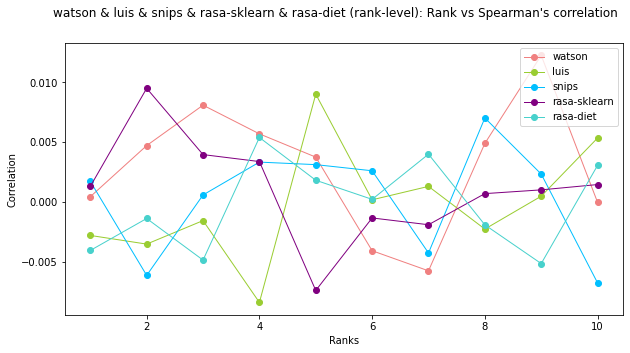

In [49]:
for i, nlu in enumerate(NLU_NAMES):
    nlu_ranks = [nlu_corr['rank'] for nlu_corr in all_nlus_correlations if nlu_corr['nlu']==nlu]
    nlu_correlations = [nlu_corr['correlation'] for nlu_corr in all_nlus_correlations if nlu_corr['nlu']==nlu]
    
    if i==0:
        fig, ax = plt.subplots(figsize=(10, 5))
    #plt.errorbar(nlu_ranks, nlu_correlations, fmt='o', yerr=sds, ls='-', capsize=10, label=nlu, color=COLORS[i])
    plt.plot(nlu_ranks, nlu_correlations, marker='o', linewidth=1, label=nlu, color=COLORS[i]) # plot without sd
    
plot_file_name = "../visualizations/correlations/v8_all_rank_corrs.pdf"
plot_title = '{} (rank-level): Rank vs Spearman\'s correlation'.format(" & ".join(NLU_NAMES))
show_reliability_plot(fig, ax, plot_file_name, plot_title, x_axis_desc='Ranks', y_axis_desc='Correlation', save=False, line=False)

## Rank-level score SD

watson


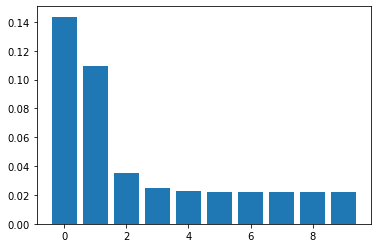

luis


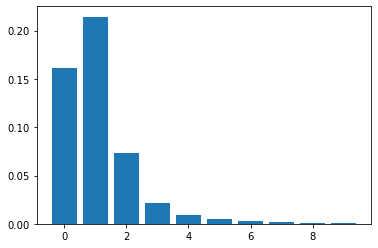

snips


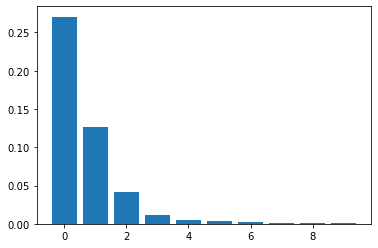

rasa-sklearn


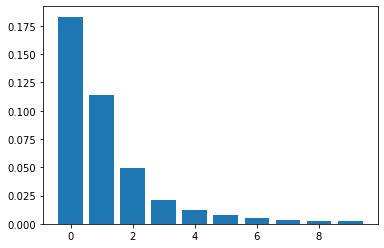

rasa-diet


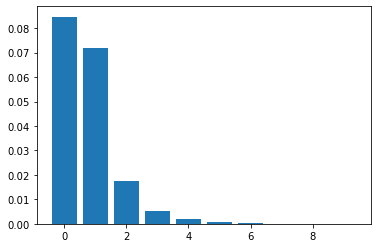

In [3]:
def get_scores(nlu, rank):
    for iteration in range(NUM_SPLITS):
        split_num = iteration + 1
        nlu_result_file = get_nlu_result_file(nlu, VERSION, split_num)
        data = remove_empty_preds(load_json(nlu_result_file))
        for test in data:
            yield test['intent_ranking'][rank]['confidence']

for i, nlu in enumerate(NLU_NAMES):
    print(nlu)
    sds = []
    for rank in range(NUM_INTENTS):
        #print('rank', rank)
        scores = list(get_scores(nlu, rank))
        sd = stdev(scores)
        #print(nlu, sd)
        sds.append(sd)
        
    fig, ax = plt.subplots()
    ax.bar(range(NUM_INTENTS), sds)
    plt.show()




